<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#TL;DR" data-toc-modified-id="TL;DR-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>TL;DR</a></span></li><li><span><a href="#Import-libs" data-toc-modified-id="Import-libs-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import libs</a></span></li><li><span><a href="#Step-by-step" data-toc-modified-id="Step-by-step-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Step-by-step</a></span><ul class="toc-item"><li><span><a href="#Debug" data-toc-modified-id="Debug-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Debug</a></span></li><li><span><a href="#Run" data-toc-modified-id="Run-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Run</a></span></li></ul></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Pipeline</a></span><ul class="toc-item"><li><span><a href="#Traffic-poisson_exp_compute_2e6" data-toc-modified-id="Traffic-poisson_exp_compute_2e6-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Traffic poisson_exp_compute_2e6</a></span><ul class="toc-item"><li><span><a href="#Choose-samples-for-1lb" data-toc-modified-id="Choose-samples-for-1lb-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Choose samples for 1lb</a></span></li></ul></li><li><span><a href="#Run-heuristics" data-toc-modified-id="Run-heuristics-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Run heuristics</a></span></li><li><span><a href="#Run-maglev" data-toc-modified-id="Run-maglev-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Run maglev</a></span></li><li><span><a href="#Run-nf-llf" data-toc-modified-id="Run-nf-llf-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Run nf-llf</a></span></li><li><span><a href="#Run-nf-po2" data-toc-modified-id="Run-nf-po2-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Run nf-po2</a></span></li><li><span><a href="#Run-weighted" data-toc-modified-id="Run-weighted-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Run weighted</a></span></li></ul></li></ul></div>

# TL;DR
This notebook is used to do unit test for each candidate load balancing method implemented for testbed.

Experiment setup:
- 1 lb
- 12 as
- poisson_lognormal trace
- [110, 112, 114, 116, 118, 120] traffic rate
- 4 as w/ colocated workload 

Candidate methods:
- Maglev (ECMP)
- Static-ws (WCMP)
- NF-LLF (LSQ)
- NF-PO2 (LSQ2)
- Heuristic-ada

# Import libs

In [1]:
import sys
import os
utils_dir = '../../src/utils'
sys.path.insert(0, utils_dir) # add utils dir to path
import testbed_utils as tu
import time

# Step-by-step

## Debug

In [2]:
tu.umount_image()

In [7]:
tu.umount_image()
# mount base image
tu.mount_new_image(tu.CONF['global']['path']['orig_img'], tu.CONF['global']['path']['base_img'])

In [81]:
img = tu.CONF['global']['path']['base_img']
cmd = "sudo modprobe nbd max_part=8;\
    sudo qemu-nbd --connect=/dev/nbd0 {};\
    sudo mount -o loop /dev/nbd0p1 {};\
    \n".format(img, tu.LOOP_DIR)
print(cmd)

sudo modprobe nbd max_part=8;    sudo qemu-nbd --connect=/dev/nbd0 /home/yzy/Load-Balancer/data/img/lb-vpp-base.img;    sudo mount -o loop /dev/nbd0p1 /mnt/loop;    



In [84]:
cmd = "sudo chown 1000:1000 {0}/home/cisco/*;\
        sudo umount {0}/;\
        sudo qemu-nbd --disconnect /dev/nbd0;\n".format(tu.LOOP_DIR)
print(cmd)

sudo chown 1000:1000 /mnt/loop/home/cisco/*;        sudo umount /mnt/loop/;        sudo qemu-nbd --disconnect /dev/nbd0;



## Unit test

In [668]:
lb_method = 'ecmp'
trace='poisson_benchmark_2'
experiment='atc-motivation'
sample='rate_300.csv'
from_orig=None
config_file_prefix='1x-1lb-88core-motiv'
colocate=None
colocate_freq=0.0001
twist=False
clip_n=10000

In [669]:
server_id = 1
if twist:
    config_file_prefix += '-twist'
config_file = config_file_prefix+'-'+str(server_id)
config_file_remote = {i: config_file_prefix+'-{}'.format(i) for i in [0, 2, 3]}
ip_remote = tu.COMMON_CONF['net']['physical_server_ip']


task_name, task_dir, nodes = tu.init_task_info(
    experiment=experiment,
    lb_method=lb_method,
    trace=trace,
    sample=sample,
    filename=config_file+'.json',
    colocate=colocate,
    colocate_freq=colocate_freq,
    alias=config_file_prefix
)

print(">> run task {}".format(task_name))

init_task_info: alias=1x-1lb-88core-motiv
alias=1x-1lb-88core-motiv
>> run task poisson_benchmark_2-ecmp-rate_300-1x-1lb-88core-motiv


In [677]:
for server_id in [0, 2, 3]:
    if clip_n and server_id == 0:
        clip_str = '-n {}'.format(clip_n)
    else:
        clip_str = ''
    
    cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/run2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json {}"'.format(
        ip_remote[server_id], experiment, colocate_freq, lb_method, trace, sample, config_file_remote[server_id], clip_str)
#     print(cmd)
    tu.subprocess.Popen(cmd, shell=True)

In [673]:
tu.prepare_img(lb_method=lb_method, from_orig=from_orig, debug_node=False)

Create LB node image...


In [674]:
tu.runall()
time.sleep(10)

node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_18 ready: ssh -p 9018 cisco@localhost
node_server_19 ready: ssh -p 9019 cisco@localhost
node_server_20 ready: ssh -p 9020 cisco@localhost
node_server_21 ready: ssh -p 9021 cisco@localhost
node_server_22 ready: ssh -p 9022 cisco@localhost
node_server_23 ready: ssh -p 9023 cisco@localhost
node_server_24 ready: ssh -p 9024 cisco@localhost
node_server_25 ready: ssh -p 9025 cisco@localhost
node_server_26 ready: ssh -p 9026 cisco@localhost
node_server_27 ready: ssh -p 9027 cisco@localhost
node_server_28 ready: ssh -p 9028 cisco@localhost
node_server_29 ready: ssh -p 9029 cisco@localhost
node_server_30 ready: ssh -p 9030 cisco@localhost
node_server_31 ready: ssh -p 9031 cisco@localhost
node_server_32 ready: ssh -p 9032 cisco@localhost
node_server_33 ready: ssh -p 9033 cisco@localhost
node_server_34 ready: ssh -p 9034 cisco@localhost
node_server_35 ready: ssh -p 9035 cisco@localhost
node_server_36 ready: ssh -p 9036 cisco@localhost
node_

In [679]:
net_ok = False
while not net_ok:
    try:
        tu.gt_socket_check()
        net_ok = True
    except:
        print('error')
        time.sleep(1)

LB Node 0: pass


In [ ]:
traffic_rate = 300
# for n_server in [88, 84, 72, 60, 48, 36, 24, 12]:
for n_server in [88]:
    print("=== Working on {} server case ===".format(n_server))
    cmd = 'ssh -t -p 8900 cisco@localhost "echo {:d} > n_log.txt"'.format(n_server)
    tu.subprocess_cmd(cmd)
    # start gathering at LB node
    for lb in tu.NODES['lb']:
        lb.run_init_bg()
    # run traffic
    t0 = time.time()
    cmd = 'ssh -t yzy@10.60.16.12 "python3 /home/yzy/Load-Balancer/src/utils/run_traffic.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json"'.format(
        experiment, colocate_freq, lb_method, trace, sample, config_file_remote[0])
    
    tu.subprocess_cmd(cmd)
    print("Trace replay over w/ total time: {:.3f}s".format(time.time()-t0))

    cmd = 'ssh -t -p 8900 cisco@localhost "sudo pkill -9 python; mv log log_{0:d}server_{1:d}rate; mkdir log"'.format(n_server, traffic_rate)
    tu.subprocess_cmd(cmd)

=== Working on 88 server case ===


In [919]:
# fetch results from nodes
    for server_id in [0, 2, 3]:
    cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/shutdown2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json --episode {}"'.format(
        ip_remote[server_id], experiment, colocate_freq, lb_method, trace, sample, config_file_remote[server_id], 1)
    if server_id == 0:
        cmd += ' --shutdown'
#     tu.subprocess.Popen(cmd, shell=True)
    print(cmd)

ssh -t yzy@10.60.16.12 "python3 /home/yzy/Load-Balancer/src/utils/shutdown2server.py --experiment atc-motivation --colocate-freq 0.0001 -m ecmp --tr poisson_benchmark_2 --sample rate_300.csv -f 1x-1lb-88core-motiv-0.json --episode 1" --shutdown
ssh -t yzy@10.60.16.15 "python3 /home/yzy/Load-Balancer/src/utils/shutdown2server.py --experiment atc-motivation --colocate-freq 0.0001 -m ecmp --tr poisson_benchmark_2 --sample rate_300.csv -f 1x-1lb-88core-motiv-2.json --episode 1"
ssh -t yzy@10.60.16.16 "python3 /home/yzy/Load-Balancer/src/utils/shutdown2server.py --experiment atc-motivation --colocate-freq 0.0001 -m ecmp --tr poisson_benchmark_2 --sample rate_300.csv -f 1x-1lb-88core-motiv-3.json --episode 1"


In [1]:
tu.NODES['lb'].run()

NameError: name 'tu' is not defined

In [898]:
tu.shutall()

# Plot

In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [181]:
def read_file(filename):
    lines = []
    with open (filename, "r") as myfile:
        lines = [line.rstrip('\n') for line in myfile]
    return lines

def parse_lb_log(filename, warmup=0.05, cooldown=0.05):
    lb_log = read_file(filename)
    lb_log_dict = {
        'step': [],
        'ts': [],
        'latency': [],
        '#apache': [],
        'cpu': [],
    }
    for l in lb_log:
        if 'Step' in l:
            step, ts = l.strip(' ').lstrip("Step: ").strip('s)').split(' (Time: ')
            lb_log_dict['step'].append(int(step))
            lb_log_dict['ts'].append(float(ts))
        elif 'latency' in l:
            lb_log_dict['latency'].append(float(l.split(': ')[-1].split('s')[0]))
        elif '#apache' in l:
            lb_log_dict['#apache'].append([int(i) for i in l.split(':')[-1].split('|')])
        elif 'cpu' in l:
            lb_log_dict['cpu'].append([float(i) for i in l.split(':')[-1].split('|')])
        else:
            continue
    for k, v in lb_log_dict.items():
        length = len(v)
        lb_log_dict[k] = v[int(warmup*length):int((1-cooldown)*length)]
    return lb_log_dict

def parse_usage_log(filename, warmup=0.05, cooldown=0.05):
    usage_log = read_file(os.path.join(log_folder, 'usage.log'))
    usage_log_dict = {
        'ts': [],
        'cpu': [],
        'used_ram': [],
        'avail_ram': []
    }
    for l in usage_log[1:]:
        elements = l.split(',')
        if len(elements) != 4: continue
        ts, cpu, used, avail = elements
        usage_log_dict['ts'].append(float(ts))
        usage_log_dict['cpu'].append(float(cpu))
        usage_log_dict['used_ram'].append(float(used))
        usage_log_dict['avail_ram'].append(float(avail))
    for k, v in usage_log_dict.items():
        length = len(v)
        usage_log_dict[k] = v[int(warmup*length):int((1-cooldown)*length)]
    return usage_log_dict

## Plot latency

In [348]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_linear_regression(x, y): 

    slope, intercept = np.polyfit(x, y, 1)  # linear model adjustment

    y_model = np.polyval([slope, intercept], x)   # modeling...

    x_mean = np.mean(x)
    y_mean = np.mean(y)
    n = x.size                        # number of samples
    m = 2                             # number of parameters
    dof = n - m                       # degrees of freedom
    t = stats.t.ppf(0.975, dof)       # Students statistic of interval confidence

    residual = y - y_model

    std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error

    # calculating the r2
    # https://www.statisticshowto.com/probability-and-statistics/coefficient-of-determination-r-squared/
    # Pearson's correlation coefficient
    numerator = np.sum((x - x_mean)*(y - y_mean))
    denominator = ( np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2) )**.5
    correlation_coef = numerator / denominator
    r2 = correlation_coef**2

    # mean squared error
    MSE = 1/n * np.sum( (y - y_model)**2 )

    # to plot the adjusted model
    x_line = np.linspace(np.min(x), np.max(x), 100)
    y_line = np.polyval([slope, intercept], x_line)

    # confidence interval
    ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
    # predicting interval
    pi = t * std_error * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5  

    ############### Ploting
    plt.rcParams.update({'font.size': 14})
    fig = plt.figure(figsize=(8,4), dpi=96)
    ax = fig.add_axes([.1, .1, .8, .8])

    ax.plot(x, y, 'o', color = 'royalblue', alpha=0.01)
    ax.plot(x_line, y_line, color = 'royalblue')

    ax.fill_between(x_line, y_line + pi, y_line - pi, color = 'lightcyan', alpha=0.3, label = '95% prediction interval')

    ax.set_xlabel(r'$x$: Number of servers')
    ax.set_ylabel(r'$y$: Latency ($\mu$s)')

    ax.fill_between(x_line, y_line + ci, y_line - ci, color = 'skyblue', label = '95% confidence interval')


    # rounding and position must be changed for each case and preference
    a = str(np.round(intercept))
    b = str(np.round(slope,2))
    r2s = str(np.round(r2,2))
    MSEs = str(np.round(MSE))

    yticks = np.arange(-1.75, -3.6, -0.25)
    plt.yticks(yticks, ['{:4.0f}'.format(i*1e6) for i in np.power(10, yticks)])

    ax.text(13, -1.8, '$\log_{10}y = ' + '{} + {}x$'.format(a, b))
    ax.text(13, -2, '$r^2$ = ' + r2s + '     MSE = ' + MSEs)
    plt.legend(bbox_to_anchor=(1, .25), fontsize=12)
    plt.show()
    
    return fig

In [920]:
def plot_linear_regression_compare(x1, y1, x2, y2): 

    def derive_model(x,y):
        slope, intercept = np.polyfit(x, y, 1)  # linear model adjustment

        y_model = np.polyval([slope, intercept], x)   # modeling...

        x_mean = np.mean(x)
        y_mean = np.mean(y)
        n = x.size                        # number of samples
        m = 2                             # number of parameters
        dof = n - m                       # degrees of freedom
        t = stats.t.ppf(0.975, dof)       # Students statistic of interval confidence

        residual = y - y_model

        std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error

        # calculating the r2
        # https://www.statisticshowto.com/probability-and-statistics/coefficient-of-determination-r-squared/
        # Pearson's correlation coefficient
        numerator = np.sum((x - x_mean)*(y - y_mean))
        denominator = ( np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2) )**.5
        correlation_coef = numerator / denominator
        r2 = correlation_coef**2


        # to plot the adjusted model
        x_line = np.linspace(np.min(x), np.max(x), 100)
        y_line = np.polyval([slope, intercept], x_line)

        # confidence interval
#         ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
        # predicting interval
        pi = t * std_error * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5  
        return x_line, y_line, pi, r2


    ############### Ploting
    fig = plt.figure(figsize=(7,3), dpi=96)
    ax = fig.add_axes([.1, .1, .8, .8])


    for i, (x, y, linestyle, color, marker_style, label) in enumerate(zip([x1, x2], [y1, y2], ['-', '-.'], ['teal', 'chocolate'], [4, 5], ['No traffic', '$4.8$kpps traffic'])):

        x_line, y_line, pi, r2 = derive_model(x, y)
        scatter_samples = np.random.choice(range(len(x)), 10000)
        ax.scatter(x[scatter_samples], y[scatter_samples], marker=marker_style, color=color, alpha=0.01)
        ax.plot(x_line, y_line, linestyle, color=color, label=label)

#         ax.plot(x_line, y_line + pi, '--', color=color, alpha=0.5)
#         ax.plot(x_line, y_line - pi, '--', color=color, alpha=0.5)
        
        ax.fill_between(x_line, y_line + pi, y_line - pi, color=color, alpha=0.1)


        # rounding and position must be changed for each case and preference
        r2s = str(np.round(r2,2))
#         ax.text(13, -2+i*0.2, '$r^2$ = ' + r2s)
    ax.fill_between([0], [0], [0], color='k', alpha=0.1, label='95% predict interval')


    ax.set_xlabel(r'Number of servers')
    ax.set_ylabel(r'Latency ($\mu$s)')

    plt.xlim([10, 90])
    plt.ylim([-3.7, -1.65])
    
    yticks = np.arange(-1.75, -3.6, -0.25)
    plt.yticks(yticks, ['{:4.0f}'.format(i*1e6) for i in np.power(10, yticks)])

    plt.xticks(n_server_list)
#     bbox_to_anchor=(0., 1.05, 1., .102), loc='lower left',
#            ncol=3, mode="expand", borderaxespad=0.)
    plt.legend(fontsize=12, loc='upper left')
    plt.grid()
    plt.show()
    
    return fig

In [921]:
traffic_rate_list = [0, 300]
# traffic_rate_list = [200, 300]
n_server_list = [12, 24, 36, 48, 60, 72, 84, 88]
# n_server_list = [12, 24, 36, 64, 72, 88]

In [922]:
data_dir = '../../data/results/atc-motivation/log'
log_fmt = 'log_{}server_{}rate'

In [923]:
all_results_dict = {}
for traffic_rate in traffic_rate_list:
    all_results_dict[traffic_rate] = {}
    for n_server in n_server_list:
        log_folder = os.path.join(data_dir, log_fmt.format(n_server, traffic_rate))
        files = !ls $log_folder
        all_results_dict[traffic_rate][n_server] = {
            'lb': parse_lb_log(os.path.join(log_folder, 'lb.log')),
#             'usage': parse_usage_log(os.path.join(log_folder, 'usage.log'))
        }
            

In [924]:
xs = {}
ys = {}
for traffic_rate in traffic_rate_list:
    xs[traffic_rate] = []
    ys[traffic_rate] = []
    for n_server in n_server_list:
        data = all_results_dict[traffic_rate][n_server]['lb']['latency']
        ys[traffic_rate] += data
        xs[traffic_rate] += [n_server]*len(data)

    xs[traffic_rate] = np.array(xs[traffic_rate])
    ys[traffic_rate] = np.log10(np.array(ys[traffic_rate]))

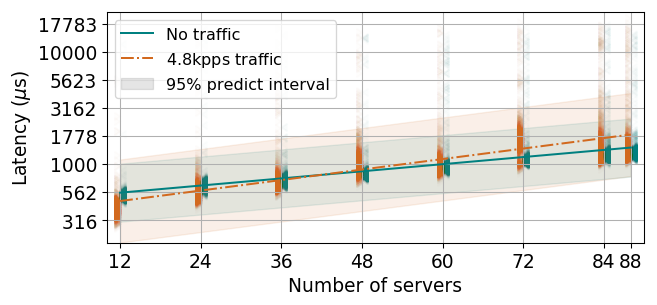

In [925]:
fig = plot_linear_regression_compare(xs[0], ys[0], xs[300], ys[300])
fig.savefig('../../data/figures/atc/motivation/compare.pdf'.format(traffic_rate), bbox_inches='tight', transparent=True)

# Plot correlation

In [881]:
traffic_rate_list = [300]
# traffic_rate_list = [200, 300]
n_server_list = [64]

In [882]:
data_dir = '../../data/results/atc-motivation/log'
log_fmt = 'log_{}server_{}rate'

In [883]:
traffic_rate = 300
n_server = 64
log_folder = os.path.join(data_dir, log_fmt.format(n_server, traffic_rate))
files = !ls $log_folder
corr_data = parse_lb_log(os.path.join(log_folder, 'lb.log'))
corr_data['ts'] = np.array(corr_data['ts'])*1000
corr_data['ts'] = corr_data['ts'].astype(int)

In [884]:
data_dict = {
    'dt': [],
    'cpu': [],
    'apache': []
}
max_dt_step = 30
warmup = 0.1
cooldown = 0.1
range_lo = int(len(corr_data['ts'])*warmup)
range_hi = int(len(corr_data['ts'])*(1-cooldown))
cpu_max = np.array(corr_data['cpu']).max()
apache_max = np.array(corr_data['#apache']).max()
for _ in range(max_dt_step):
    for i in range(range_lo+_, range_hi+_, max_dt_step):
        for ii in range(1, max_dt_step+1):
            for j in range(88-64, 88):
                data_dict['dt'].append(corr_data['ts'][i+ii] - corr_data['ts'][i])
                data_dict['cpu'].append((corr_data['cpu'][i][j]-corr_data['cpu'][i+ii][j]))
                data_dict['apache'].append((corr_data['#apache'][i][j]-corr_data['#apache'][i+ii][j]))

In [885]:
import pandas as pd
data_df = pd.DataFrame.from_dict(data_dict)

In [886]:
data_df['range1'] = pd.cut(data_df.dt, range(50, 2400, 100), include_lowest=True)

In [887]:
arr = np.array(range(50, 2400, 100))
data_df['range1'] = arr.searchsorted(data_df.dt)-1

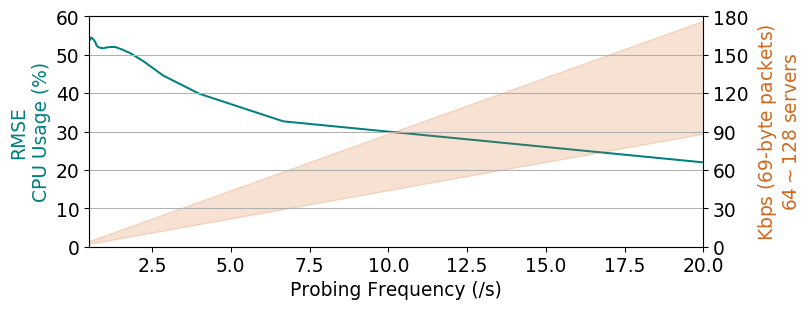

In [890]:
fig = plt.figure(figsize=(8,3), dpi=96)
ax = fig.add_axes([.1, .1, .8, .8])

x = 1000/arr[::-1]
cpu_rmse = []
# apache_rmse = []
for i in np.sort(data_df.range1.unique())[::-1]:
    data_ = data_df.loc[data_df.range1 == i]
    cpu_rmse.append(np.sqrt(1/len(data_)*np.sum(data_.cpu.values**2))*100)
#     apache_rmse.append(np.sqrt(1/len(data_)*np.sum(data_.apache.values**2)))
cpu_rmse = np.array(cpu_rmse)
# apache_rmse = np.array(apache_rmse)
    
ax.plot(x, cpu_rmse, color='teal')
# ax.plot(x, apache_rmse, color='chocolate', label='#Thread')

# ax.plot(x_line, y_line, linestyle, color=color, label=label)

# #         ax.plot(x_line, y_line + pi, '--', color=color, alpha=0.5)
# #         ax.plot(x_line, y_line - pi, '--', color=color, alpha=0.5)

#     ax.fill_between(x_line, y_line + pi, y_line - pi, color=color, alpha=0.1)


#     # rounding and position must be changed for each case and preference
#     r2s = str(np.round(r2,2))
# #         ax.text(13, -2+i*0.2, '$r^2$ = ' + r2s)
# ax.fill_between([0], [0], [0], color='k', alpha=0.1, label='95% predict interval')

ax.set_ylim([0, 60])
# ax.set_yscale('log')
ax.set_xlabel('Probing Frequency (/s)')
ax.set_ylabel('RMSE\nCPU Usage (%)', color='teal')
# ax.set_yticks(color='teal')

ax2 = ax.twinx()

ax2.fill_between(x, x*128*69/1000, x*64*69/1000, color='chocolate', alpha=0.2)


ax2.set_ylabel('Kbps ($69$-byte packets)\n$64\sim128$ servers', color='chocolate')
ax2.set_ylim([0, 180])
ax2.set_yticks(range(0, 200, 30))

plt.xlim([0.5, 20])
# plt.ylim([-3.7, -1.65])
plt.grid()


plt.show()
fig.savefig('../../data/figures/atc/motivation/visibility.pdf'.format(traffic_rate), bbox_inches='tight', transparent=True)

# Plot Pearson correlation

In [655]:
traffic_rate_list = [300]
# traffic_rate_list = [200, 300]
n_server_list = [64]

In [656]:
data_dir = '../../data/results/atc-motivation/log'
log_fmt = 'log_{}server_{}rate'

In [657]:
traffic_rate = 300
n_server = 64
log_folder = os.path.join(data_dir, log_fmt.format(n_server, traffic_rate))
files = !ls $log_folder
corr_data = parse_lb_log(os.path.join(log_folder, 'lb.log'))
corr_data['ts'] = np.array(corr_data['ts'])*1000
corr_data['ts'] = corr_data['ts'].astype(int)

In [658]:
data_dict = {
    'dt': [],
    'cpu_predict': [],
    'cpu_target': [],
    'apache_predict': [],
    'apache_target': []
}
max_dt_step = 30
warmup = 0.1
cooldown = 0.1
range_lo = int(len(corr_data['ts'])*warmup)
range_hi = int(len(corr_data['ts'])*(1-cooldown))
cpu_max = np.array(corr_data['cpu']).max()
apache_max = np.array(corr_data['#apache']).max()
for _ in range(max_dt_step):
    for i in range(range_lo+_, range_hi+_, max_dt_step):
        for ii in range(1, max_dt_step+1):
            for j in range(88-64, 88):
                data_dict['dt'].append(corr_data['ts'][i+ii] - corr_data['ts'][i])
                data_dict['cpu_predict'].append(corr_data['cpu'][i][j])
                data_dict['cpu_target'].append(corr_data['cpu'][i+ii][j])
                data_dict['apache_predict'].append(corr_data['#apache'][i][j])
                data_dict['apache_target'].append(corr_data['#apache'][i+ii][j])

In [659]:
import pandas as pd
data_df = pd.DataFrame.from_dict(data_dict)

In [660]:
data_df['range1'] = pd.cut(data_df.dt, range(50, 2400, 100), include_lowest=True)

In [661]:
arr = np.array(range(50, 2400, 100))
data_df['range1'] = arr.searchsorted(data_df.dt)-1

In [662]:
from scipy.stats import pearsonr, spearmanr
# calculate Pearson's correlation
# corr, _ = pearsonr(data1, data2)


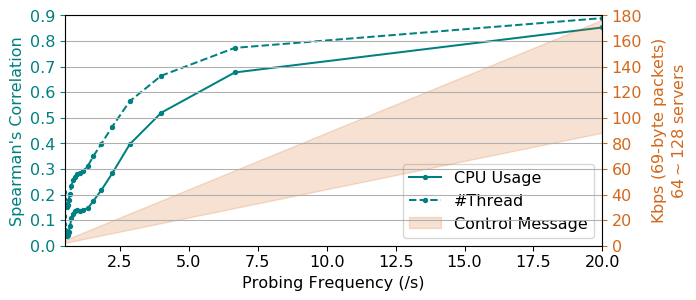

In [667]:
fig = plt.figure(figsize=(7,3), dpi=96)
ax = fig.add_axes([.1, .1, .8, .8])

corr_fn = spearmanr

x = 1000/arr[::-1]
cpu_corr = []
apache_corr = []
for i in np.sort(data_df.range1.unique())[::-1]:
    data_ = data_df.loc[data_df.range1 == i]
    corr, _ = corr_fn(data_.cpu_predict, data_.cpu_target)
    cpu_corr.append(corr)
    corr, _ = corr_fn(data_.apache_predict, data_.apache_target)
    apache_corr.append(corr)
cpu_corr = np.array(cpu_corr)
apache_corr = np.array(apache_corr)
    
ax.plot(x, cpu_corr, '-', marker='.', color='teal', label='CPU Usage')
ax.plot(x, apache_corr, '--', marker='.', color='teal', label='#Thread')
# ax.plot(x, apache_rmse, color='chocolate', label='#Thread')
ax.fill_between([0], [0], [0], color='chocolate', alpha=0.2, label='Control Message')


plt.legend()
# ax.plot(x_line, y_line, linestyle, color=color, label=label)

# #         ax.plot(x_line, y_line + pi, '--', color=color, alpha=0.5)
# #         ax.plot(x_line, y_line - pi, '--', color=color, alpha=0.5)

#     ax.fill_between(x_line, y_line + pi, y_line - pi, color=color, alpha=0.1)


#     # rounding and position must be changed for each case and preference
#     r2s = str(np.round(r2,2))
# #         ax.text(13, -2+i*0.2, '$r^2$ = ' + r2s)
# ax.fill_between([0], [0], [0], color='k', alpha=0.1, label='95% predict interval')

ax.set_ylim([0, 0.9])
# ax.set_yscale('log')
ax.set_xlabel('Probing Frequency (/s)')
ax.set_ylabel('Spearman\'s Correlation', color='teal')
ax.set_yticks(np.arange(0, 1, 0.1))
ax.tick_params(axis='y', colors='teal')

ax2 = ax.twinx()

ax2.fill_between(x, x*128*69/1000, x*64*69/1000, color='chocolate', alpha=0.2)


ax2.set_ylabel('Kbps ($69$-byte packets)\n$64\sim128$ servers', color='chocolate')
ax2.set_ylim([0, 180])
ax2.set_yticks(range(0, 200, 20))
ax2.tick_params(axis='y', colors='chocolate')
plt.xlim([0.5, 20])
# plt.ylim([-3.7, -1.65])
plt.grid()


plt.show()
fig.savefig('../../data/figures/atc/motivation/corr.pdf'.format(traffic_rate), bbox_inches='tight', transparent=True)